# Installation

In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%pip uninstall -y tempo_embeddings
%pip install -e ..

Found existing installation: tempo_embeddings 0.0.1
Uninstalling tempo_embeddings-0.0.1:
  Successfully uninstalled tempo_embeddings-0.0.1
Note: you may need to restart the kernel to use updated packages.
Obtaining file:///Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for tempo_embeddings (pyproject.toml) ... done
  Created wheel for tempo_embeddings: filename=tempo_embeddings-0.0.1-0.editable-py3-none-any.whl size=9685 sha256=108522f1fc5476415106086a23eef4173cdc98961ebeb00c8cff2d64d13fd9ca
  Stored in directory: /private/var/folders/d8/j5_fyf8941j_492zvf8948y40000gn/T/pip-ephem-wheel-cache-ryyakm_8/wheels/9d/dd/1c/d0e8ab6bde11a84556c00bd645333aaad0b90e2c38e11b0ed1
Successfully built tempo_embeddings
Note: you may need to r

In [12]:
%pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


# Initialize Database

In [13]:
%autoreload now

ERROR:root:No corpus directory found in [PosixPath('/Users/carstenschnober/Documents/SemanticsOfSustainability/data/Joris'), PosixPath('/Users/carstenschnober/SEED_DATA/SemanticsSustainability'), PosixPath('/data/datasets/research-semantics-of-sustainability/semantics-of-sustainability/data'), PosixPath('/Users/carstenschnober/data'), PosixPath('/Volumes/i-lab.data.uu.nl/research-semantics-of-sustainability/semantics-of-sustainability/data')]


In [14]:
from ipywidgets import widgets

from tempo_embeddings.settings import WEAVIATE_SERVERS

default_host = WEAVIATE_SERVERS[0][1]

host_selector = widgets.Dropdown(
    options=WEAVIATE_SERVERS, value=default_host, description="DB Server:"
)
host_selector

Dropdown(description='DB Server:', options=(('UU', ('semantics-of-sustainability.hum.uu.nl', 443, True)), ('Re…

In [15]:
from tempo_embeddings import settings

weaviate_api_key = widgets.Password(
    description="Weaviate API Key", value=settings.WEAVIATE_API_KEY or ""
)
weaviate_api_key

Password(description='Weaviate API Key')

In [16]:
from tempo_embeddings.embeddings.weaviate_database import WeaviateDatabaseManager
from tempo_embeddings.settings import DEFAULT_LANGUAGE_MODEL

host, port, secure = host_selector.value

db = WeaviateDatabaseManager.from_args(
    model_name=DEFAULT_LANGUAGE_MODEL,
    http_host=host,
    http_port=port,
    http_secure=secure,
    api_key=weaviate_api_key.value,
)

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Search

In [17]:
from ipywidgets import widgets

collections = list(db.get_available_collections())

collection_selector = widgets.SelectMultiple(
    options=collections,
    value=collections,
    description="Choose a Collection:",
    disabled=False,
    style={"description_width": "initial"},
)
collection_selector

SelectMultiple(description='Choose a Collection:', index=(0, 1, 2, 3, 4, 5, 6, 7), options=('PeopleAndParliame…

In [18]:
text_widget = widgets.Text(
    placeholder="Enter a term",
    description="Search Term:",
    disabled=False,
    value="duurzaam",
)
text_widget

Text(value='duurzaam', description='Search Term:', placeholder='Enter a term')

In [19]:
field = "genre"

## Retrieve genres from database:
# genres: set[str] = {
#     value
#     for collection in collection_selector.value
#     for value in db.get_metadata_values(collection, field)
# }

## Pre-defined genres (from newspaper sources):
genres: set[str] = {
    "familiebericht",
    "artikel",
    "illustratie met onderschrift",
    "advertentie",
}

exclude_genres = widgets.SelectMultiple(
    options=genres, value=["advertentie"], description=f"Exclude {field}(s):"
)
exclude_genres

SelectMultiple(description='Exclude genre(s):', index=(1,), options=('artikel', 'advertentie', 'familiebericht…

In [20]:
metadata_not = {field: list(exclude_genres.value)}

# Plot Frequencies

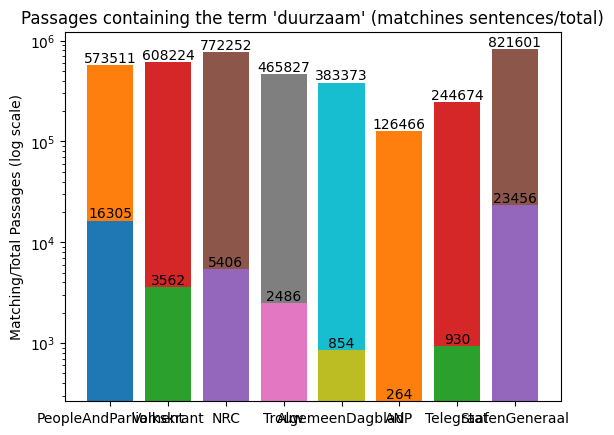

In [ ]:
import matplotlib.pyplot as plt

assert text_widget.value.strip(), "No search term provided"

fig, ax = plt.subplots()

ax.set_title(
    f"Passages containing the term '{text_widget.value}' (matching sentences/total)"
)

scale = "log"
ax.set_ylabel(f"Matching/Total Passages ({scale} scale)")
ax.set_yscale(scale)

for collection in collection_selector.value:
    doc_freq = db.doc_frequency(
        text_widget.value, collection, metadata_not=metadata_not
    )
    total_count = db.doc_frequency("", collection, metadata_not=metadata_not)

    bar_matches = ax.bar(collection, doc_freq, label=f"{collection} - Matches")
    ax.bar_label(bar_matches, fmt="%d", label_type="edge")

    bar_total = ax.bar(
        collection,
        total_count - doc_freq,
        bottom=doc_freq,
        label=f"{collection} - Total",
    )
    ax.bar_label(bar_total, fmt="%d", label_type="edge")

# Frequencies Per Year

In [22]:
start = 1850
end = 2024

year_range = widgets.SelectionRangeSlider(
    options=[str(i) for i in range(start, end)], index=(100, 150), description="Years"
)
year_range

SelectionRangeSlider(description='Years', index=(100, 150), options=('1850', '1851', '1852', '1853', '1854', '…

In [23]:
normalize = widgets.Checkbox(
    value=True, description="Normalize Frequencies", disabled=False
)
normalize

Checkbox(value=True, description='Normalize Frequencies')

In [24]:
import pandas as pd
from tqdm import tqdm

doc_freqs = pd.DataFrame(
    index=range(int(year_range.value[0]), int(year_range.value[1]))
)

for collection in tqdm(collection_selector.value, unit="collection"):
    doc_freqs[collection] = db.doc_frequencies_per_year(
        text_widget.value,
        collection,
        int(year_range.value[0]),
        int(year_range.value[1]),
    )

100%|██████████| 8/8 [00:31<00:00,  3.89s/collection]


<Axes: title={'center': "Normalized Frequency of 'duurzaam' (Rolling Average over 5 years)"}, xlabel='Year', ylabel='Normalized Frequency'>

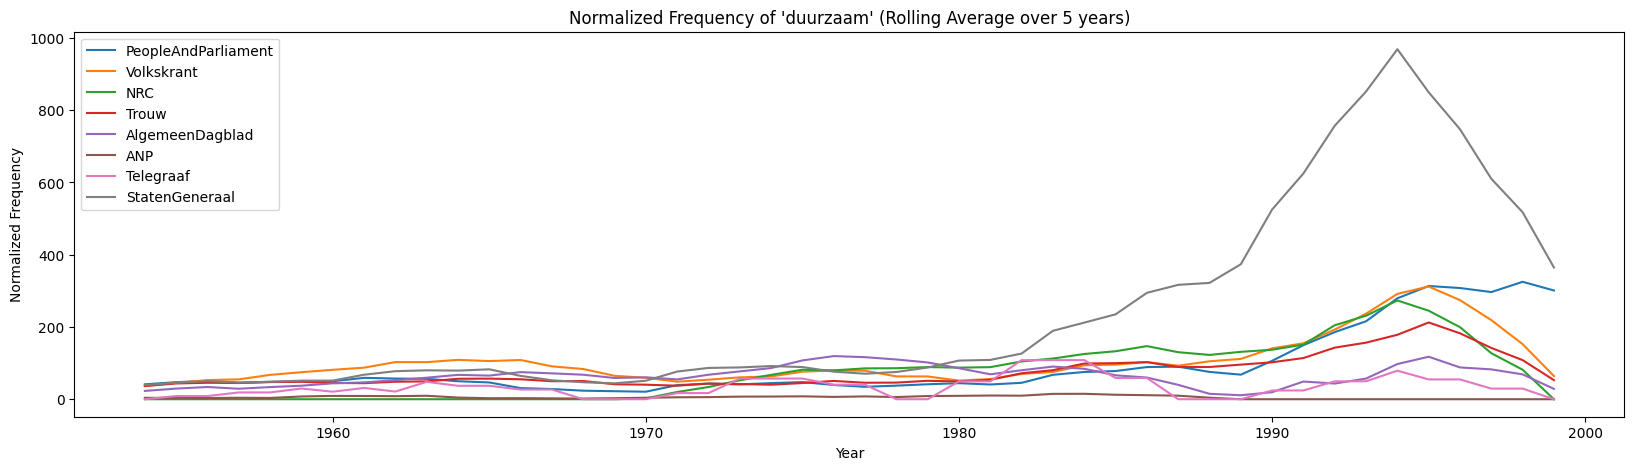

In [25]:
window_size = 5
_prefix = "Normalized " if normalize.value else ""

doc_freqs.rolling(window_size).mean().plot(
    figsize=(20, 5),
    title=f"{_prefix}Frequency of '{text_widget.value}' (Rolling Average over {window_size} years)",
    xlabel="Year",
    ylabel=f"{_prefix}Frequency",
)

# Create Corpus

In [56]:
%autoreload now

Using corpus directory: '/Volumes/i-lab.data.uu.nl/research-semantics-of-sustainability/semantics-of-sustainability/data'


In [57]:
collections = [
    db.get_corpus(
        collection,
        [text_widget.value],
        year_from=year_range.value[0],
        year_to=year_range.value[1],
        include_embeddings=True,
        metadata_not=metadata_not,
        limit=5000,
    )
    for collection in collection_selector.value
]

## Expand Corpus with Close Passages

In [58]:
distance_widget = widgets.FloatSlider(
    value=0.4, min=0, max=1, step=0.01, description="Distance Threshold"
)

distance_widget

FloatSlider(value=0.4, description='Distance Threshold', max=1.0, step=0.01)

In [59]:
from tqdm import tqdm

from tempo_embeddings.text.corpus import Corpus
from tempo_embeddings.text.passage import Passage
from tempo_embeddings.text.year_span import YearSpan

all_passages: set[Passage] = {
    passage for corpus in collections for passage in corpus.passages
}

neighbours: dict[Corpus, Corpus] = {
    collection: db.neighbours(
        collection,
        k=len(collection),  # at most, double the collection
        collections=collection_selector.value,
        distance=distance_widget.value,
        year_span=YearSpan(year_range.value[0], year_range.value[1]),
        metadata_not=metadata_not,
        exclude_passages=all_passages,
    )
    for collection in tqdm(collections, unit="collection", desc="Getting Neighbours")
}


ERROR:WeaviateDatabaseManager:Error while querying collection 'StatenGeneraal': Query call with protocol GRPC search failed with message grpc: trying to send message larger than max (127168124 vs. 104858000).

Getting Neighbours:  38%|███▊      | 3/8 [09:46<16:17, 195.43s/collection]
ERROR:WeaviateDatabaseManager:Error while querying collection 'StatenGeneraal': Query call with protocol GRPC search failed with message grpc: trying to send message larger than max (123713794 vs. 104858000).

ERROR:WeaviateDatabaseManager:Error while querying collection 'StatenGeneraal': Query call with protocol GRPC search failed with message grpc: trying to send message larger than max (123626873 vs. 104858000).

ERROR:WeaviateDatabaseManager:Error while querying collection 'StatenGeneraal': Query call with protocol GRPC search failed with message grpc: trying to send message larger than max (124121642 vs. 104858000).

ERROR:WeaviateDatabaseManager:Error while querying collection 'StatenGeneraal': Quer

In [60]:
label_length: int = max(len(collection.label) for collection in collections)

print(
    f"{'Collection Label'.ljust(label_length)}\tSize\tNeighbours with Distance < {distance_widget.value}"
)
for collection in collections:
    print(
        f"{collection.label.ljust(label_length)}\t{len(collection)}\t{len(neighbours[collection])}"
    )

Collection Label               	Size	Neighbours with Distance < 0.4
PeopleAndParliament: 'duurzaam'	5000	5000
Volkskrant: 'duurzaam'         	2887	2887
NRC: 'duurzaam'                	2534	2534
Trouw: 'duurzaam'              	2392	2392
AlgemeenDagblad: 'duurzaam'    	854	854
ANP: 'duurzaam'                	250	250
Telegraaf: 'duurzaam'          	539	539
StatenGeneraal: 'duurzaam'     	5000	5000


# Merge Collections

In [61]:
%autoreload now

In [62]:
from tempo_embeddings.text.corpus import Corpus

_neighbours = list(neighbours.values()) if neighbours else []

corpus = sum(collections + _neighbours, Corpus())
corpus.label = "Newspapers plus Neighbours"

In [63]:
corpus.compress_embeddings()

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


array([[ 2.04337192, -2.16573787],
       [ 1.15183711, -4.74063587],
       [ 1.42436326, -4.62686682],
       ...,
       [-0.66291177, -0.81842965],
       [-1.18047476,  0.97687757],
       [-1.1591022 ,  0.98575008]])

## Plot Corpus

In [64]:
from tempo_embeddings.settings import STOPWORDS
from tempo_embeddings.text.keyword_extractor import KeywordExtractor

keyword_extractor = KeywordExtractor(
    corpus, exclude_words=STOPWORDS | {text_widget.value}
).fit()

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [68]:
%autoreload now

In [69]:
from tempo_embeddings.text.keyword_extractor import KeywordExtractor
from tempo_embeddings.visualization.jscatter import JScatterVisualizer

visualizer = JScatterVisualizer(
    collections + _neighbours, keyword_extractor=keyword_extractor
)
visualizer.visualize()

Button(description='Cluster', style=ButtonStyle(), tooltip='Cluster the data')

DownloadButton(description='Export', style=ButtonStyle())

Button(description='Cluster', style=ButtonStyle(), tooltip='Cluster the data')

DownloadButton(description='Export', style=ButtonStyle())

In [ ]:
import logging

import matplotlib.pyplot as plt

if visualizer.clusters:
    clusters = visualizer.clusters

    fig, ax = plt.subplots()
    fig.set_figheight(len(clusters) // 5)

    ax.barh([c.top_words_string() for c in clusters], [len(c) for c in clusters])
    ax.set_title(f"Cluster Sizes for '{text_widget.value}'")
else:
    logging.error(
        "No clusters found. Click the 'Cluster' button in the scatter plot above."
    )

AttributeError: 'JScatterVisualizer' object has no attribute 'clusters'

# Cluster-based Statistics

In [ ]:
import random

cluster_selector = widgets.Dropdown(
    options=[(cluster.top_words_string(), i) for i, cluster in enumerate(clusters)],
    value=random.randint(0, len(clusters) - 1),
    description="Choose a Cluster:",
)
cluster_selector

NameError: name 'clusters' is not defined

In [ ]:
cluster: Corpus = clusters[cluster_selector.value]

<Axes: title={'center': "Relative frequency of cluster 'energiebesparing;beleid;energie;kernenergie;regering;punt;zaken;kamer' by collection"}, xlabel='collection', ylabel='Sentence Count'>

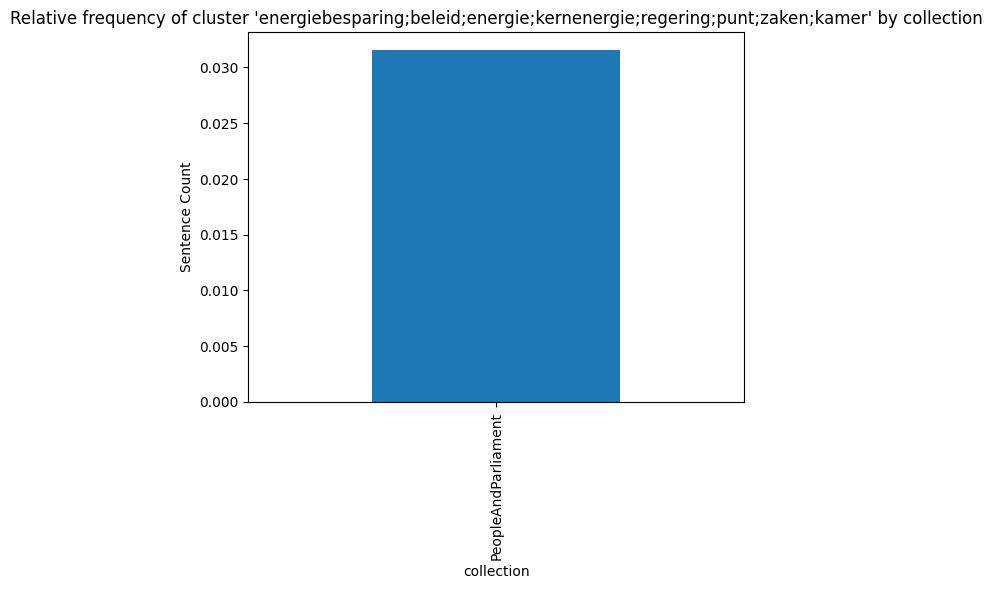

In [ ]:
import pandas as pd

field = "collection"

corpus_per_newspaper = pd.Series(corpus.get_metadatas(field)).value_counts()

cluster_per_newspaper = pd.Series(cluster.get_metadatas(field)).value_counts()

(cluster_per_newspaper / corpus_per_newspaper).sort_index().plot(
    kind="bar",
    title=f"Relative frequency of cluster '{cluster.top_words_string()}' by {field}",
    xlabel=field,
    ylabel="Sentence Count",
)

In [ ]:
field = "date"

corpus_per_year = pd.Series(corpus.get_metadatas(field)).dt.year.value_counts()

<Axes: title={'center': "Cluster 'energiebesparing;beleid;energie;kernenergie;regering;punt;zaken;kamer' (Rolling average over 5 years)"}, xlabel='date', ylabel='Sentence Count'>

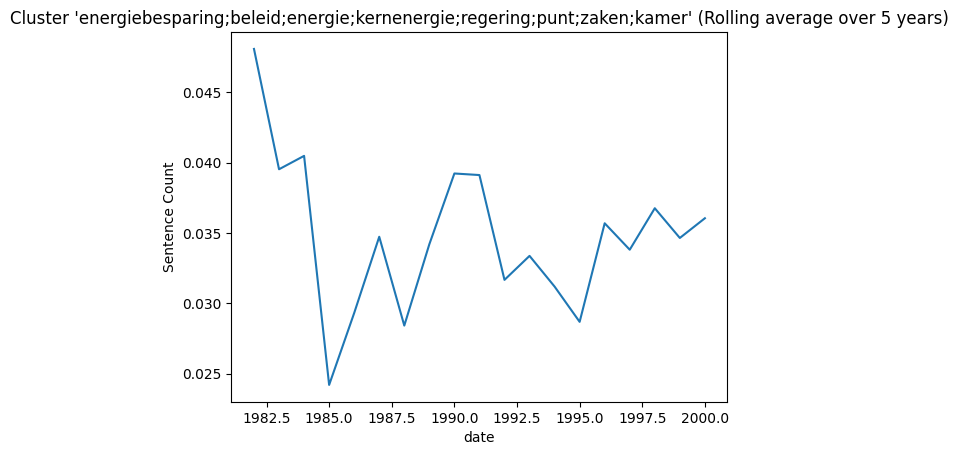

In [ ]:
cluster_years = pd.Series(cluster.get_metadatas(field)).dt.year

(cluster_years.value_counts() / corpus_per_year).sort_index().rolling(
    window_size
).mean().plot(
    title=f"Cluster '{cluster.top_words_string()}' (Rolling average over {window_size} years)",
    xlabel=field,
    ylabel="Sentence Count",
)

In [ ]:
clusters_per_year = []
for c in clusters:
    if not c.is_outliers():
        s = pd.Series(c.get_metadatas(field)).dt.year.value_counts() / corpus_per_year
        s.name = c.top_words_string()
        clusters_per_year.append(s)

clusters_per_year = pd.concat(clusters_per_year, axis=1)

<Axes: title={'center': 'Yearly Distribution of Clusters'}>

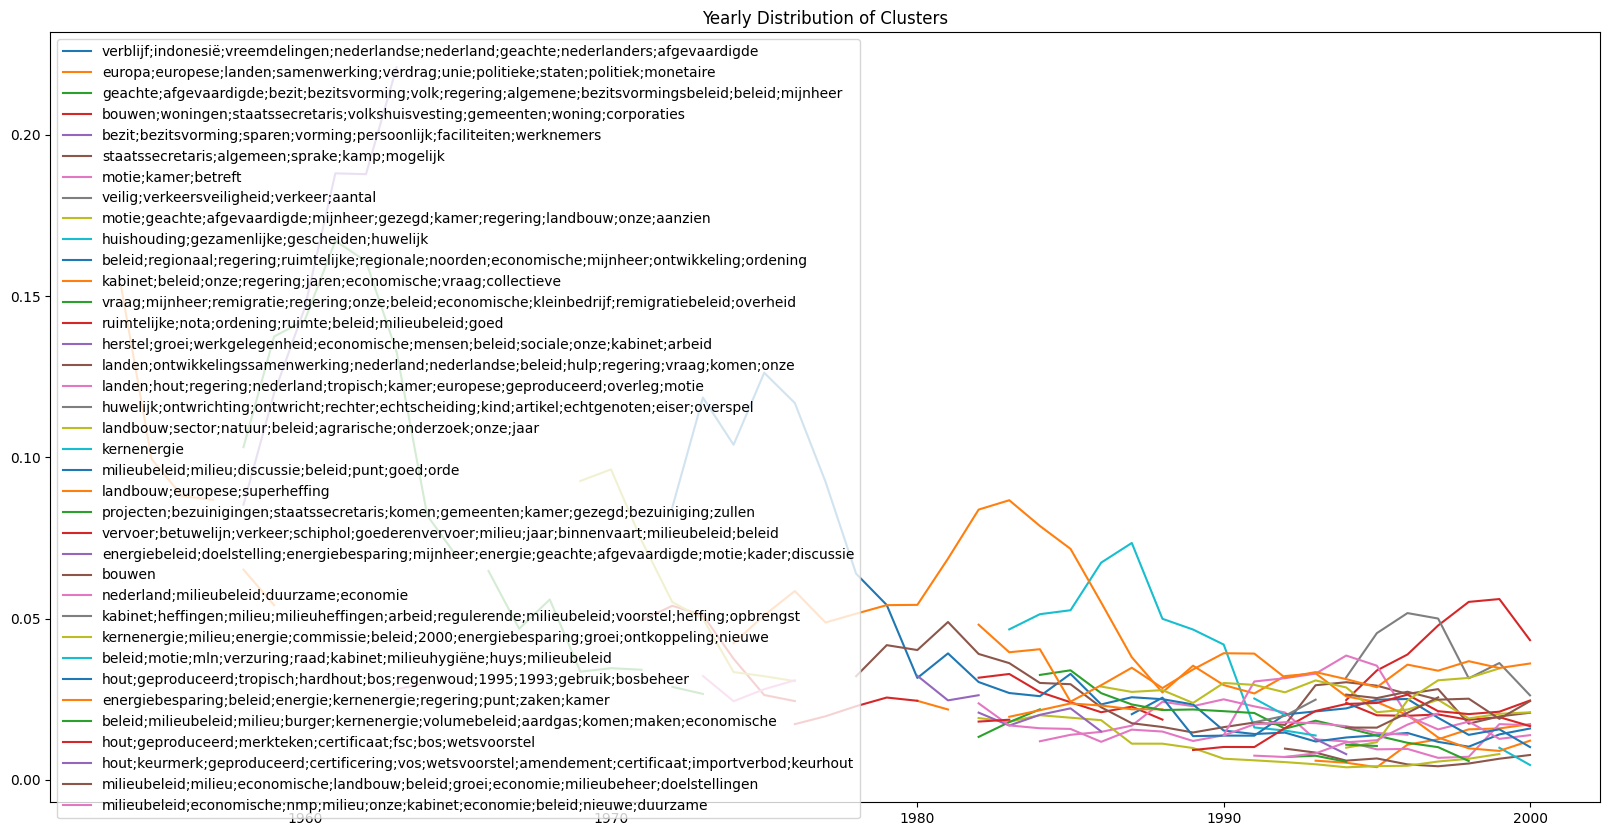

In [ ]:
clusters_per_year.sort_index().rolling(window_size).mean().plot(
    kind="line", figsize=(20, 10), title="Yearly Distribution of Clusters"
)

## Cluster Analysis per Years

In [ ]:
windows = sorted(
    cluster.windows(5, start=int(year_range.value[0]), stop=int(year_range.value[1])),
    key=lambda c: c.label,
)

In [ ]:
print(f"Windows for cluster '{cluster}':")
for window in windows:
    window.top_words = keyword_extractor.top_words(window)

    print(window)

Windows for cluster 'Corpus('Newspapers plus Neighbours; cluster 8', 327 passages, top words=['energiebesparing', 'beleid', 'energie', 'kernenergie', 'regering', 'punt', 'zaken', 'kamer'])':
Corpus('Newspapers plus Neighbours; cluster 8 1970-1975', 22 passages, top words=['dolman', 'mijnheer', 'aardgas', 'regering', 'oriënteringsnota', 'verheugt', 'wetsontwerp', 'onze', 'aardolie', 'energienota'])
Corpus('Newspapers plus Neighbours; cluster 8 1975-1980', 28 passages, top words=['kernenergie', 'brandstofinzetplan', 'structuurnota', 'regering', 'australië', 'ondernemingsraad', 'zaken', 'vreedzame', 'canada', 'zweden'])
Corpus('Newspapers plus Neighbours; cluster 8 1980-1985', 56 passages, top words=['kernenergie', 'beleid', 'discussie', 'economische', 'energiebesparing', 'besluitvorming', 'energiebeleid', 'extra', 'regering', 'zaken'])
Corpus('Newspapers plus Neighbours; cluster 8 1985-1990', 41 passages, top words=['mln', 'sep', 'kernenergie', 'energiebesparing', 'heroverweging', 'zijls

In [ ]:
cluster_extractor = KeywordExtractor(
    cluster, exclude_words=STOPWORDS | {text_widget.value}
).fit()

/Users/carstenschnober/Documents/SemanticsOfSustainability/workspace/tempo-embeddings/.venv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
print(
    f"Frequent words per window relative to this cluster ({cluster.top_words_string()}):"
)
print("-" * 80)

for window in windows:
    print(window)
    print(cluster_extractor.top_words(window))

Frequent words per window relative to this cluster (energiebesparing;beleid;energie;kernenergie;regering;punt;zaken;kamer):
--------------------------------------------------------------------------------
Corpus('Newspapers plus Neighbours; cluster 8 1970-1975', 22 passages, top words=['dolman', 'mijnheer', 'aardgas', 'regering', 'oriënteringsnota', 'verheugt', 'wetsontwerp', 'onze', 'aardolie', 'energienota'])
['mijnheer', 'wetsontwerp', 'onze', 'dolman', 'regering', 'meen', 'zeggen', 'aardgas', 'oriënteringsnota', 'verheugt']
Corpus('Newspapers plus Neighbours; cluster 8 1975-1980', 28 passages, top words=['kernenergie', 'brandstofinzetplan', 'structuurnota', 'regering', 'australië', 'ondernemingsraad', 'zaken', 'vreedzame', 'canada', 'zweden'])
['regering', 'structuurnota', 'kernenergie', 'brandstofinzetplan', 'antwoord', 'zaken', 'resultaten', 'daarover', 'zien', 'mijnheer']
Corpus('Newspapers plus Neighbours; cluster 8 1980-1985', 56 passages, top words=['kernenergie', 'beleid', '